# Brain Tumor Classifier using Convolution Neural Networks

##### The Following notebook classifies the three most prevalent types of Brain tumor types. The dataset is has t1-weighted fMRI images of Meningioma, glioma, and tumor of the pituitary. Out of these, Meningioma makes up to about 37% of all primary brain tumors. 70% of which are benign but can cause other issues. Glioma an umbrella term for various glial cell tumors such as such as glioblastoma, ependymomas, astrocytomas, and oligodendrogliomas, makes up 81% of malignant brain tumors. This project report discusses the tumor of the pituitary gland which with an occurrence rate of 15% between all brain tumors.

### Importing necassary modules

In [33]:
import h5py as h5
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from PIL import ImageEnhance  
import cv2
import tensorflow as tf
import pathlib
import os, shutil

import keras 
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
from keras import optimizers
from keras.layers import Activation, SimpleRNN#, hidden_units
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

class Patient(object):
    PID = ""
    image=""
    label=""
    tumorBorder=""
    tumorMask=""
    
    def __init__(self, PID, image, label,tumorBorder,tumorMask):
        self.PID = PID
        self.image = image
        self.label = label
        self.tumorBorder=tumorBorder
        self.tumorMask=tumorMask


#### Directory Confirmation
•	The dataset can be downloaded from https://figshare.com/articles/brain_tumor_dataset/1512427
	Cited:  Cheng, Jun (2017): brain tumor dataset. figshare. Dataset. https://doi.org/10.6084/m9.figshare.1512427.v5


In [34]:

datdir = pathlib.Path('C:\\Anaconda3\\3246\\Project1')
image_count = len(list(datdir.glob('*/*.mat')))
print('Count',image_count,"MRI images")
data_dir = pathlib.Path('C:\\Anaconda3\\3246\\Project1\\brainTumorDataPublic_1-766')

Count 3064 MRI images


##### The dataset provides with slices of patient T1-weighted fMRI in the following numbers:
Meningioma (708 slices), Glioma (1426 slices), and Pituitary tumor (930 slices)

The slices are stored as .mat matrix file with information labelled as patient ID, listed as an array of integers. The dataset includes tumor labels (1 for meningioma, 2 for glioma, 3 for pituitary tumor), tumor border which is a vector storing the coordinates of discrete points on tumor border like [x1, y1, x2, y2,...] where x1, y1 are planar coordinates on tumor border. The dataset also has tumor Mask which is a binary image with 1’s indicating tumor region. All of this listed information acts as a supplement to the Image data information. The images have a plane resolution of 512×512 where the f-MRI’s slice thickness is 6 mm and the slice gap is 1 mm. The values for image data is stored from pixel values to generate a heatmap.


### Custom functions 

In [35]:
def plotFile(i):
    f = h5.File('C:\\Anaconda3\\3246\\Project1\\brainTumorDataPublic_1-766\\'+str(i),"r")
    list(f.keys())
        
    list(f['/cjdata'].keys())

    
    p=Patient('','','','','')
    p.image=np.array(f['/cjdata/image'])
    p.PID=np.array(f['/cjdata/PID'])
    p.label=np.array(f['/cjdata/label'])
    p.tumorBorder=np.mat(f['/cjdata/tumorBorder'])
    p.tumorMask=np.array(f['/cjdata/tumorMask'])
    return (p.image,p.label,p.tumorMask)

def TumorClass(model,img_path):# To test the saved model with one of the images
    model = load_model(model)
    img = image.load_img(img_path, target_size=(150, 150))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    ans= model.predict(img_tensor)
    if ans[0][0]>(ans[0][1] and ans[0][2]):
        return print("glioma")
    if ans[0][1]>(ans[0][0] and ans[0][2]):
        return print("meningioma")
    if ans[0][2]>(ans[0][1] and ans[0][0]):
        return print("pituitary tumor")

def TumorEnhance(x,t,n,b):#x is for train or test, t istumor type, n is blend % and b is brightness
        
        fig.savefig(x+t+filename + '.png')
        fig.savefig(x+str(1)+t+filename + '.png')
        imga= Image.open(x+str(1)+t+filename + '.png')
        imga = imga.crop((55, 35, 320, 250))
        imga.save(x+str(1)+t+filename + '.png',"PNG")
        
        img = Image.open(x+t+filename + '.png')#.convert('LA')

        fig.clf()
        p.tumorMask=np.mat(f['/cjdata/tumorMask'])
        sns_plot2=sns.heatmap(p.tumorMask)
        fig2 = sns_plot2.get_figure()
        fig.savefig(x+t+filename + 'b.png')  
        img2 = Image.open(x+t+filename + 'b.png')

                    
        new_img = Image.blend(img2, img,n)
        new_img = new_img.crop((55, 35, 320, 250))
        new_img.save(x+t+filename + '.png',"PNG")
        
        new_img = Image.open(x+t+filename + '.png')
        ImageEnhance.Brightness(new_img).enhance(b).save(x+t+filename + '.png')
        os.remove(x+t+filename + 'b.png')
        

The Seaborn heatmap module creates a PNG file of the figure with attached axis and legend that can be removed but leave a white margin in the image file nonetheless. Function named “TumorEnhanced” was created to serve multiple purposes. The function’s step by step approach function is listed below:

1)	The image and the tumor-mask could be saved and cropped in such a way that the dimensions of both the image and the mask would be consistent with both images 215x265.

2)	The image could be adjusted for brightness to for better feature detection.

3)	The tumor mask image with binary numbers can be layered on top of the f-MRI image to further enhance and contrast the tumor.

4)	The Tumor-mask image was then deleted to only keep the enhanced fMRI image.

5)	The image was saved with no tumor enhancement in train1 folder or test1 folder, while the tumor enhanced images would be stored in the train and test folder.


### Creation of Train and Test directories with enhanced images and Train1 Test1 with the same but un-enunhanced images 

In [36]:
#To be used only only to recreate a dataset split, otherwise leave commented.
base_dir='C:\\Anaconda3\\3246\\Project1\\'
# shutil.rmtree('C:\\Anaconda3\\3246\\Project1\\train')
# shutil.rmtree('C:\\Anaconda3\\3246\\Project1\\train1')
# shutil.rmtree('C:\\Anaconda3\\3246\\Project1\\test')
# shutil.rmtree('C:\\Anaconda3\\3246\\Project1\\test1')


train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
train_m_dir = os.path.join(train_dir, 'm')
os.mkdir(train_m_dir)
train_g_dir = os.path.join(train_dir, 'g')
os.mkdir(train_g_dir)
train_p_dir = os.path.join(train_dir, 'p')
os.mkdir(train_p_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)
test_m_dir = os.path.join(test_dir, 'm')
os.mkdir(test_m_dir)
test_g_dir = os.path.join(test_dir, 'g')
os.mkdir(test_g_dir)
test_p_dir = os.path.join(test_dir, 'p')
os.mkdir(test_p_dir)

train1_dir = os.path.join(base_dir, 'train1')
os.mkdir(train1_dir)
train_m_dir = os.path.join(train1_dir, 'm')
os.mkdir(train_m_dir)
train_g_dir = os.path.join(train1_dir, 'g')
os.mkdir(train_g_dir)
train_p_dir = os.path.join(train1_dir, 'p')
os.mkdir(train_p_dir)

test1_dir = os.path.join(base_dir, 'test1')
os.mkdir(test1_dir)
test_m_dir = os.path.join(test1_dir, 'm')
os.mkdir(test_m_dir)
test_g_dir = os.path.join(test1_dir, 'g')
os.mkdir(test_g_dir)
test_p_dir = os.path.join(test1_dir, 'p')
os.mkdir(test_p_dir)


#### Random integer generator seperates the datset in a 75:25 Train:Test split with enhanced and non-unhanced images pre-processed with the functions above.

Train1 and test1 folder has unenhanced images from the dataset whereas train and test folder has enhanced images. A random float generator was used to split the image dataset with 75% used for training and 25% of dataset used for validation. Both train1 and train, test and test1 have folders titled “m” for meningioma, “g” for “glioma”, and “p” for pituitary tumor class. The images are the same in both training and testing sets with the only difference being that of enhancement to test out if enhancing the tumor would help in classification of the dataset.

In [37]:
data_dir = pathlib.Path('C:\\Anaconda3\\3246\\Project1\\brainTumorDataPublic_1-766')


#Brightness for secondary test train
bright=1.1
blend=0.85

#Counts for train and test
cntrain=0
cntest=0

print("Processing filename: ", end="")
Path=str(data_dir)
for filename in os.listdir(data_dir):
    if filename.endswith(".mat"):
        print(filename+"...", end =" ")
        with h5.File(Path+"\\"+filename, 'r') as f:
            list(f.keys())
            list(f['/cjdata'].keys())
            p=Patient('','','','','')
            p.image=np.mat(f['/cjdata/image'])
            sns_plot=sns.heatmap(p.image)
            p.label=np.array(f['/cjdata/label'])                   
            fig = sns_plot.get_figure()         
            ran_num=np.random.rand(1)
            if ran_num <= 0.25:
                if p.label[0][0]==1:
                    TumorEnhance('test','//m//',blend,bright)
                elif p.label[0][0]==2:
                    TumorEnhance('test','//g//',blend,bright)
                elif p.label[0][0]==3:
                    TumorEnhance('test','//p//',blend,bright)
                cntest=cntest+1               
            elif ran_num > 0.25:
                if p.label[0][0]==1:
                    TumorEnhance('train','//m//',blend,bright)
                elif p.label[0][0]==2:
                    TumorEnhance('train','//g//',blend,bright)
                elif p.label[0][0]==3:
                    TumorEnhance('train','//p//',blend,bright)
                cntrain=cntrain+1
            fig.clf()
print("")
print("")

print(cntrain/(cntrain+cntest),"% of images used for training")
print(cntest/(cntrain+cntest),"% of images used for testing")           

Processing filename: 1.mat... 10.mat... 100.mat... 1000.mat... 1001.mat... 1002.mat... 1003.mat... 1004.mat... 1005.mat... 1006.mat... 1007.mat... 1008.mat... 1009.mat... 101.mat... 1010.mat... 1011.mat... 1012.mat... 1013.mat... 1014.mat... 1015.mat... 1016.mat... 1017.mat... 1018.mat... 1019.mat... 102.mat... 1020.mat... 1021.mat... 1022.mat... 1023.mat... 1024.mat... 1025.mat... 1026.mat... 1027.mat... 1028.mat... 1029.mat... 103.mat... 1030.mat... 1031.mat... 1032.mat... 1033.mat... 1034.mat... 1035.mat... 1036.mat... 1037.mat... 1038.mat... 1039.mat... 104.mat... 1040.mat... 1041.mat... 1042.mat... 1043.mat... 1044.mat... 1045.mat... 1046.mat... 1047.mat... 1048.mat... 1049.mat... 105.mat... 1050.mat... 1051.mat... 1052.mat... 1053.mat... 1054.mat... 1055.mat... 1056.mat... 1057.mat... 1058.mat... 1059.mat... 106.mat... 1060.mat... 1061.mat... 1062.mat... 1063.mat... 1064.mat... 1065.mat... 1066.mat... 1067.mat... 1068.mat... 1069.mat... 107.mat... 1070.mat... 1071.mat... 1072.mat

1618.mat... 1619.mat... 162.mat... 1620.mat... 1621.mat... 1622.mat... 1623.mat... 1624.mat... 1625.mat... 1626.mat... 1627.mat... 1628.mat... 1629.mat... 163.mat... 1630.mat... 1631.mat... 1632.mat... 1633.mat... 1634.mat... 1635.mat... 1636.mat... 1637.mat... 1638.mat... 1639.mat... 164.mat... 1640.mat... 1641.mat... 1642.mat... 1643.mat... 1644.mat... 1645.mat... 1646.mat... 1647.mat... 1648.mat... 1649.mat... 165.mat... 1650.mat... 1651.mat... 1652.mat... 1653.mat... 1654.mat... 1655.mat... 1656.mat... 1657.mat... 1658.mat... 1659.mat... 166.mat... 1660.mat... 1661.mat... 1662.mat... 1663.mat... 1664.mat... 1665.mat... 1666.mat... 1667.mat... 1668.mat... 1669.mat... 167.mat... 1670.mat... 1671.mat... 1672.mat... 1673.mat... 1674.mat... 1675.mat... 1676.mat... 1677.mat... 1678.mat... 1679.mat... 168.mat... 1680.mat... 1681.mat... 1682.mat... 1683.mat... 1684.mat... 1685.mat... 1686.mat... 1687.mat... 1688.mat... 1689.mat... 169.mat... 1690.mat... 1691.mat... 1692.mat... 1693.mat... 

2239.mat... 224.mat... 2240.mat... 2241.mat... 2242.mat... 2243.mat... 2244.mat... 2245.mat... 2246.mat... 2247.mat... 2248.mat... 2249.mat... 225.mat... 2250.mat... 2251.mat... 2252.mat... 2253.mat... 2254.mat... 2255.mat... 2256.mat... 2257.mat... 2258.mat... 2259.mat... 226.mat... 2260.mat... 2261.mat... 2262.mat... 2263.mat... 2264.mat... 2265.mat... 2266.mat... 2267.mat... 2268.mat... 2269.mat... 227.mat... 2270.mat... 2271.mat... 2272.mat... 2273.mat... 2274.mat... 2275.mat... 2276.mat... 2277.mat... 2278.mat... 2279.mat... 228.mat... 2280.mat... 2281.mat... 2282.mat... 2283.mat... 2284.mat... 2285.mat... 2286.mat... 2287.mat... 2288.mat... 2289.mat... 229.mat... 2290.mat... 2291.mat... 2292.mat... 2293.mat... 2294.mat... 2295.mat... 2296.mat... 2297.mat... 2298.mat... 2299.mat... 23.mat... 230.mat... 2300.mat... 2301.mat... 2302.mat... 2303.mat... 2304.mat... 2305.mat... 2306.mat... 2307.mat... 2308.mat... 2309.mat... 231.mat... 2310.mat... 2311.mat... 2312.mat... 2313.mat... 23

286.mat... 2860.mat... 2861.mat... 2862.mat... 2863.mat... 2864.mat... 2865.mat... 2866.mat... 2867.mat... 2868.mat... 2869.mat... 287.mat... 2870.mat... 2871.mat... 2872.mat... 2873.mat... 2874.mat... 2875.mat... 2876.mat... 2877.mat... 2878.mat... 2879.mat... 288.mat... 2880.mat... 2881.mat... 2882.mat... 2883.mat... 2884.mat... 2885.mat... 2886.mat... 2887.mat... 2888.mat... 2889.mat... 289.mat... 2890.mat... 2891.mat... 2892.mat... 2893.mat... 2894.mat... 2895.mat... 2896.mat... 2897.mat... 2898.mat... 2899.mat... 29.mat... 290.mat... 2900.mat... 2901.mat... 2902.mat... 2903.mat... 2904.mat... 2905.mat... 2906.mat... 2907.mat... 2908.mat... 2909.mat... 291.mat... 2910.mat... 2911.mat... 2912.mat... 2913.mat... 2914.mat... 2915.mat... 2916.mat... 2917.mat... 2918.mat... 2919.mat... 292.mat... 2920.mat... 2921.mat... 2922.mat... 2923.mat... 2924.mat... 2925.mat... 2926.mat... 2927.mat... 2928.mat... 2929.mat... 293.mat... 2930.mat... 2931.mat... 2932.mat... 2933.mat... 2934.mat... 29

760.mat... 761.mat... 762.mat... 763.mat... 764.mat... 765.mat... 766.mat... 767.mat... 768.mat... 769.mat... 77.mat... 770.mat... 771.mat... 772.mat... 773.mat... 774.mat... 775.mat... 776.mat... 777.mat... 778.mat... 779.mat... 78.mat... 780.mat... 781.mat... 782.mat... 783.mat... 784.mat... 785.mat... 786.mat... 787.mat... 788.mat... 789.mat... 79.mat... 790.mat... 791.mat... 792.mat... 793.mat... 794.mat... 795.mat... 796.mat... 797.mat... 798.mat... 799.mat... 8.mat... 80.mat... 800.mat... 801.mat... 802.mat... 803.mat... 804.mat... 805.mat... 806.mat... 807.mat... 808.mat... 809.mat... 81.mat... 810.mat... 811.mat... 812.mat... 813.mat... 814.mat... 815.mat... 816.mat... 817.mat... 818.mat... 819.mat... 82.mat... 820.mat... 821.mat... 822.mat... 823.mat... 824.mat... 825.mat... 826.mat... 827.mat... 828.mat... 829.mat... 83.mat... 830.mat... 831.mat... 832.mat... 833.mat... 834.mat... 835.mat... 836.mat... 837.mat... 838.mat... 839.mat... 84.mat... 840.mat... 841.mat... 842.mat..

<Figure size 432x288 with 0 Axes>

# PreProcessing with image train and validation generator

### Using Target size of 150x150

In [38]:

CLASS_NAMES = np.array(['meningioma','glioma','pituatory tumor'])

train_dir = 'C:\\Anaconda3\\3246\\Project1\\train'
validation_dir = 'C:\\Anaconda3\\3246\\Project1\\test'

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)


test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        #we use categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

Found 2266 images belonging to 3 classes.
Found 798 images belonging to 3 classes.


In [39]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 150, 150, 3)
labels batch shape: (32, 3)


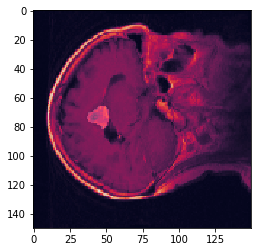

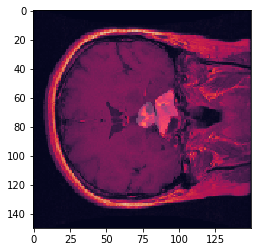

In [40]:
i = 0
for batch in train_generator:
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0][0]))
    i += 1
    if i % 2 == 0:
        break

## Creating simplified sequential model

Each “block" in the simplified model above consists of a single convolution-2d layer and a max-pooling layer with only 4 blocks instead of 5. This was then similarly flattened with 1 x 1 x 6272 as the output dimensions. This was then connected to a dense layer of 1 x 1 x 512 with ReLU activation and subsequently into the classifier output of 1 x 1 x 3 with sigmoid activation. ReLu stands for rectified linear unit. It is computationally cheaper to compute and converges faster. Linearity indicates that the slope does not plateau or saturate. The sigmoid activation is used because it outputs smooth or continuous range of values between 0’s which would be considered a better option for categorical classification.


In [41]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))


model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(3, activation='sigmoid'))
model.summary()


model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.25e-4),
              metrics=['acc'])



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

## Model 1 (Enhanced) image processing layer by layer

In [42]:
# Random image from the test data, insert any other image if this particular image is instead randomly selected for training
img_path = 'C:\\Anaconda3\\3246\\Project1\\test\\m\\124.mat.png'
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
#<1> Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 150, 150, 3)


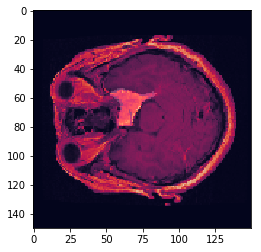

In [43]:
plt.imshow(img_tensor[0])
plt.show()

In [44]:
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [45]:
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


##### Visualizing the 4th channel of first layer of the simplified model

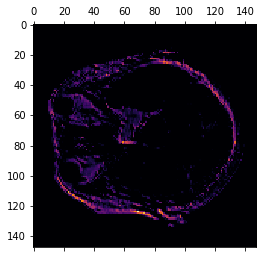

In [46]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap='inferno')

##### Visualizing the 7th channel of first layer of the simplified model

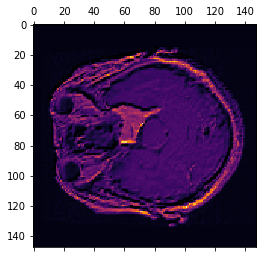

In [47]:
plt.matshow(first_layer_activation[0, :, :, 7], cmap='inferno')

As seen above, the fourth channel acts as a high contrast fine edge detection with seventh activation layer detecting the gradients and textures in the skull and brain-matter of the MRI.

##### Visualizing the the image tensor outputs of all the layers of the simplified model with an enhanced image

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


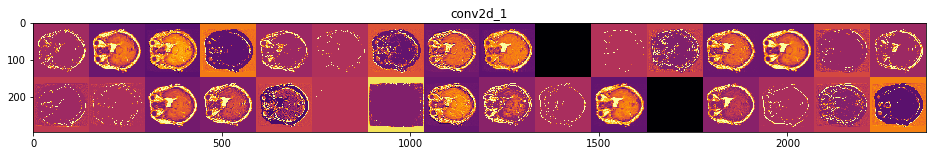

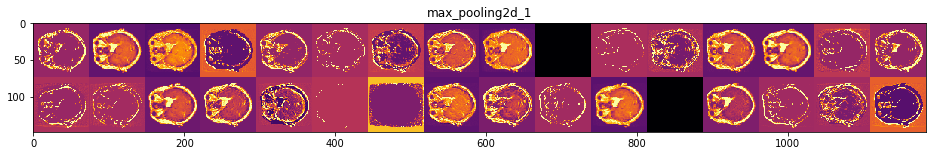

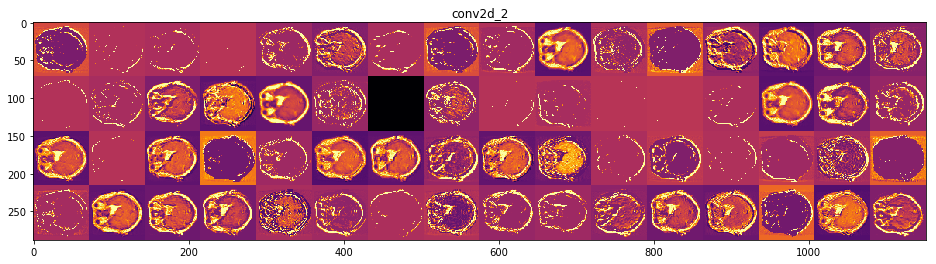

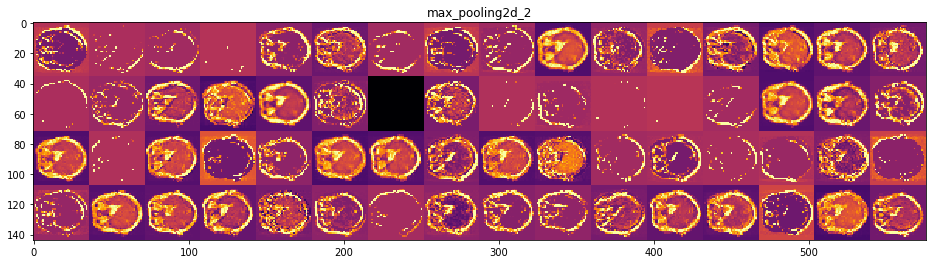

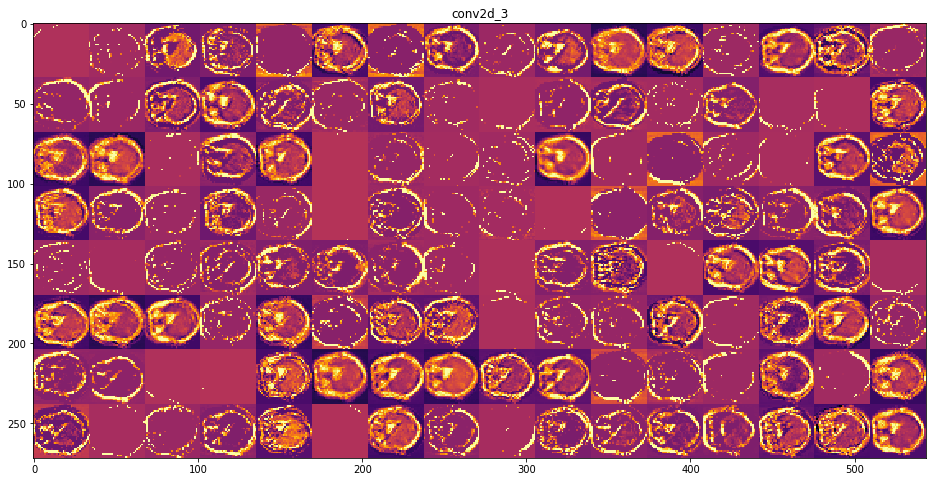

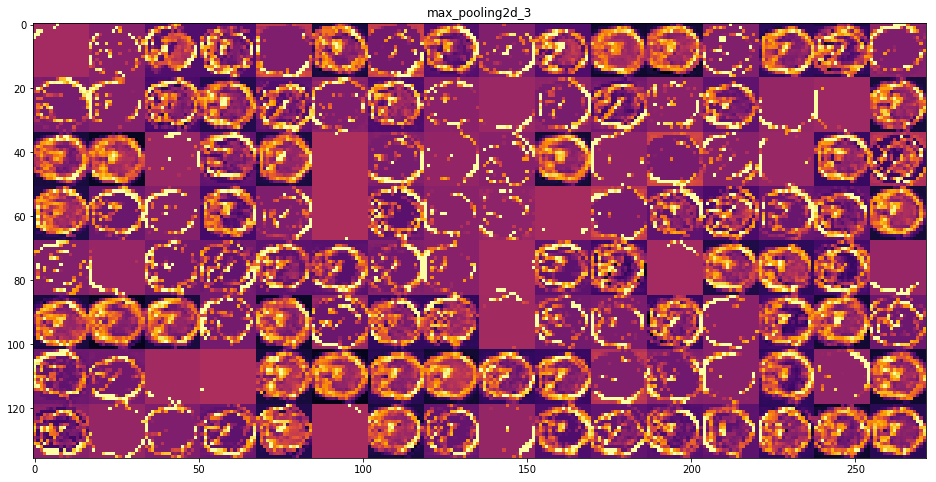

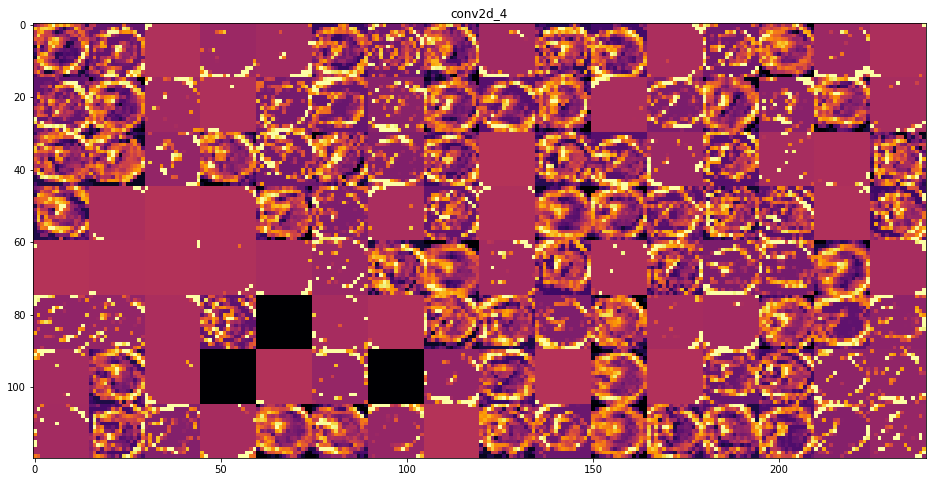

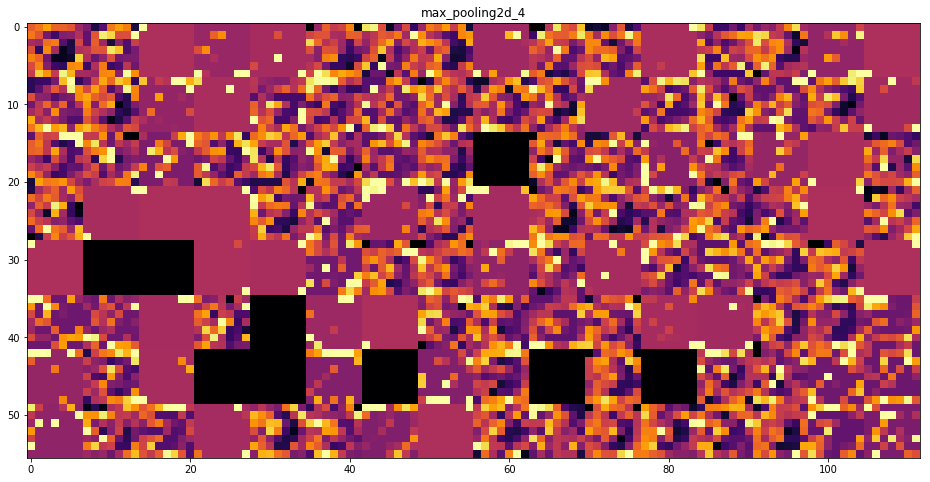

In [48]:
#Plotting for each layer
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='inferno')

As we go further with the blocks of the CNN’s the activations become increasingly abstract and less visually interpretable. They begin to encode higher level concepts such as skull, tumor region, cerebellum, brain matter etc. Higher representations carry increasingly less information about the visual contents about the image and increasingly more information related to the class of the image. Furthermore, the sparsity of the activations increases with the depth of the layers. In the first layer, all filters are activated by the input image and in the final layers, a few filters are blank. This means that the pattern encoded by the filter was not found in the input image. They however do carry extremely pixelated conceptualization of the tumor and its proximity skull and the grey-white matter around it. 

# Fit generator for the entire dataset with enhanced images

In [49]:
 
filepath="Simplified_enhanced_Brain_Tumor_class.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
term=keras.callbacks.TerminateOnNaN()

callbacks_list = [checkpoint,term]


history = model.fit_generator(train_generator,
                              steps_per_epoch=20,
                              epochs=175,
                              validation_data=validation_generator,
                              validation_steps=50,
                              callbacks=callbacks_list)

Epoch 1/175
20/20 [==============================] - 51s 3s/step - loss: 1.0754 - acc: 0.4734 - val_loss: 1.0576 - val_acc: 0.4612

Epoch 00001: val_acc improved from -inf to 0.46115, saving model to Simplified_enhanced_Brain_Tumor_class.hdf5
Epoch 2/175
20/20 [==============================] - 47s 2s/step - loss: 1.0399 - acc: 0.4703 - val_loss: 1.0195 - val_acc: 0.4612

Epoch 00002: val_acc improved from 0.46115 to 0.46115, saving model to Simplified_enhanced_Brain_Tumor_class.hdf5
Epoch 3/175
20/20 [==============================] - 46s 2s/step - loss: 0.9929 - acc: 0.4672 - val_loss: 0.9621 - val_acc: 0.4612

Epoch 00003: val_acc did not improve from 0.46115
Epoch 4/175
20/20 [==============================] - 43s 2s/step - loss: 0.9337 - acc: 0.5462 - val_loss: 0.8562 - val_acc: 0.6942

Epoch 00004: val_acc improved from 0.46115 to 0.69424, saving model to Simplified_enhanced_Brain_Tumor_class.hdf5
Epoch 5/175
20/20 [==============================] - 44s 2s/step - loss: 0.8120 - a


Epoch 00040: val_acc did not improve from 0.86466
Epoch 41/175
20/20 [==============================] - 63s 3s/step - loss: 0.3934 - acc: 0.8344 - val_loss: 0.3815 - val_acc: 0.8571

Epoch 00041: val_acc did not improve from 0.86466
Epoch 42/175
20/20 [==============================] - 46s 2s/step - loss: 0.3826 - acc: 0.8422 - val_loss: 0.3677 - val_acc: 0.8697

Epoch 00042: val_acc improved from 0.86466 to 0.86967, saving model to Simplified_enhanced_Brain_Tumor_class.hdf5
Epoch 43/175
20/20 [==============================] - 45s 2s/step - loss: 0.3798 - acc: 0.8392 - val_loss: 0.3840 - val_acc: 0.8584

Epoch 00043: val_acc did not improve from 0.86967
Epoch 44/175
20/20 [==============================] - 44s 2s/step - loss: 0.3540 - acc: 0.8641 - val_loss: 0.3555 - val_acc: 0.8471

Epoch 00044: val_acc did not improve from 0.86967
Epoch 45/175
20/20 [==============================] - 45s 2s/step - loss: 0.3668 - acc: 0.8609 - val_loss: 0.3475 - val_acc: 0.8835

Epoch 00045: val_acc

20/20 [==============================] - 43s 2s/step - loss: 0.2523 - acc: 0.8946 - val_loss: 0.2483 - val_acc: 0.9085

Epoch 00082: val_acc improved from 0.90852 to 0.90852, saving model to Simplified_enhanced_Brain_Tumor_class.hdf5
Epoch 83/175
20/20 [==============================] - 44s 2s/step - loss: 0.2123 - acc: 0.9266 - val_loss: 0.2710 - val_acc: 0.8885

Epoch 00083: val_acc did not improve from 0.90852
Epoch 84/175
20/20 [==============================] - 45s 2s/step - loss: 0.2266 - acc: 0.9141 - val_loss: 0.2941 - val_acc: 0.8885

Epoch 00084: val_acc did not improve from 0.90852
Epoch 85/175
20/20 [==============================] - 50s 2s/step - loss: 0.2789 - acc: 0.9047 - val_loss: 0.2405 - val_acc: 0.9085

Epoch 00085: val_acc did not improve from 0.90852
Epoch 86/175
20/20 [==============================] - 47s 2s/step - loss: 0.2235 - acc: 0.9161 - val_loss: 0.3010 - val_acc: 0.8672

Epoch 00086: val_acc did not improve from 0.90852
Epoch 87/175
20/20 [==============


Epoch 00123: val_acc did not improve from 0.93358
Epoch 124/175
20/20 [==============================] - 39s 2s/step - loss: 0.1788 - acc: 0.9328 - val_loss: 0.1802 - val_acc: 0.9348

Epoch 00124: val_acc improved from 0.93358 to 0.93484, saving model to Simplified_enhanced_Brain_Tumor_class.hdf5
Epoch 125/175
20/20 [==============================] - 38s 2s/step - loss: 0.1416 - acc: 0.9578 - val_loss: 0.1796 - val_acc: 0.9348

Epoch 00125: val_acc improved from 0.93484 to 0.93484, saving model to Simplified_enhanced_Brain_Tumor_class.hdf5
Epoch 126/175
20/20 [==============================] - 40s 2s/step - loss: 0.1461 - acc: 0.9516 - val_loss: 0.2231 - val_acc: 0.8997

Epoch 00126: val_acc did not improve from 0.93484
Epoch 127/175
20/20 [==============================] - 44s 2s/step - loss: 0.1531 - acc: 0.9531 - val_loss: 0.1767 - val_acc: 0.9361

Epoch 00127: val_acc improved from 0.93484 to 0.93609, saving model to Simplified_enhanced_Brain_Tumor_class.hdf5
Epoch 128/175
20/20 [

20/20 [==============================] - 37s 2s/step - loss: 0.0861 - acc: 0.9797 - val_loss: 0.1462 - val_acc: 0.9511

Epoch 00165: val_acc improved from 0.94612 to 0.95113, saving model to Simplified_enhanced_Brain_Tumor_class.hdf5
Epoch 166/175
20/20 [==============================] - 37s 2s/step - loss: 0.0836 - acc: 0.9766 - val_loss: 0.1739 - val_acc: 0.9336

Epoch 00166: val_acc did not improve from 0.95113
Epoch 167/175
20/20 [==============================] - 36s 2s/step - loss: 0.0982 - acc: 0.9668 - val_loss: 0.1577 - val_acc: 0.9398

Epoch 00167: val_acc did not improve from 0.95113
Epoch 168/175
20/20 [==============================] - 36s 2s/step - loss: 0.0980 - acc: 0.9703 - val_loss: 0.1756 - val_acc: 0.9273

Epoch 00168: val_acc did not improve from 0.95113
Epoch 169/175
20/20 [==============================] - 37s 2s/step - loss: 0.0946 - acc: 0.9750 - val_loss: 0.1507 - val_acc: 0.9398

Epoch 00169: val_acc did not improve from 0.95113
Epoch 170/175
20/20 [=========

### Plotting train and validation loss and accuracy

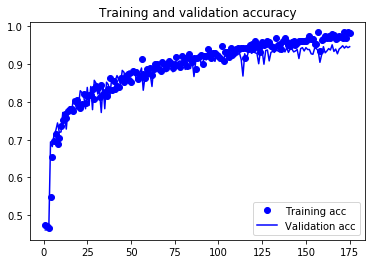

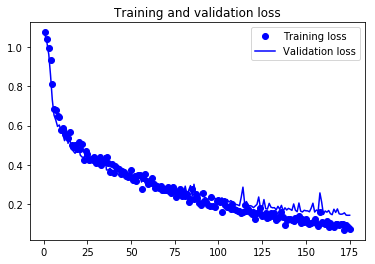

In [50]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Second model used by training with NON-enhanced images

In [ ]:
#Non-enhanced images train and validation directory
train_dir1 = 'C:\\Anaconda3\\3246\\Project1\\train1'
validation_dir1 = 'C:\\Anaconda3\\3246\\Project1\\test1'

# All images will be rescaled by 1./255
train_datagen1 = ImageDataGenerator(rescale=1./255)
test_datagen1 = ImageDataGenerator(rescale=1./255)

train_generator1 = train_datagen1.flow_from_directory(
        # This is the target directory
        train_dir1,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        #we use categorical labels
        class_mode='categorical')

validation_generator1 = test_datagen1.flow_from_directory(
        validation_dir1,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

Found 2266 images belonging to 3 classes.
Found 798 images belonging to 3 classes.


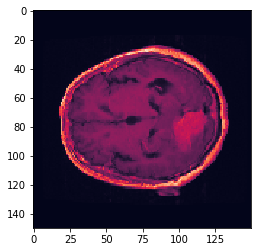

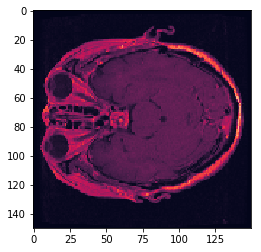

In [ ]:
# This is module with image preprocessing utilities

i = 0
for batch in train_generator1:
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0][0]))
    i += 1
    if i % 2 == 0:
        break

In [ ]:
# Creating a sequential model
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dense(3, activation='sigmoid'))
model2.summary()

model2.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=.25e-4),
              metrics=['acc'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

## Model 2 (Non-enhanced) image processing layer by layer

In [ ]:
#Please manually select any random image in the test1 folder
img_path = 'C:\\Anaconda3\\3246\\Project1\\test1\\m\\124.mat.png' #Random image from test1 enhanced dataset
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
#<1> Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 150, 150, 3)


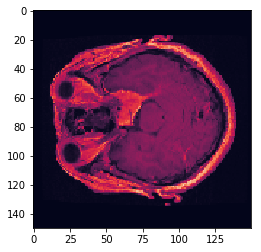

In [ ]:

plt.imshow(img_tensor[0])
plt.show()

In [ ]:

layer_outputs = [layer.output for layer in model2.layers[:8]]
activation_model = models.Model(inputs=model2.input, outputs=layer_outputs)

In [ ]:
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


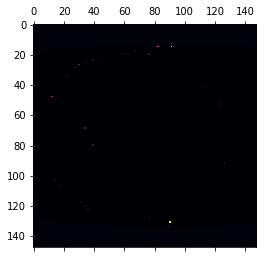

In [ ]:

plt.matshow(first_layer_activation[0, :, :, 4], cmap='inferno')

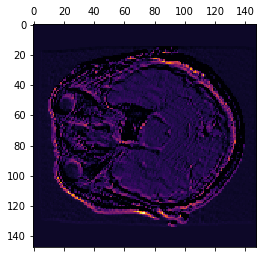

In [ ]:
plt.matshow(first_layer_activation[0, :, :, 7], cmap='inferno')

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


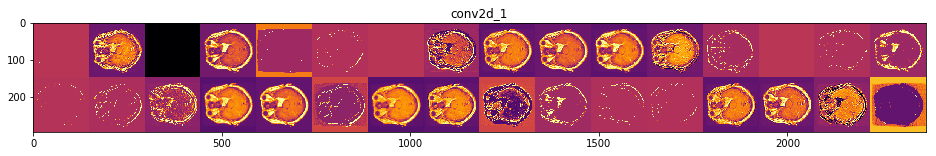

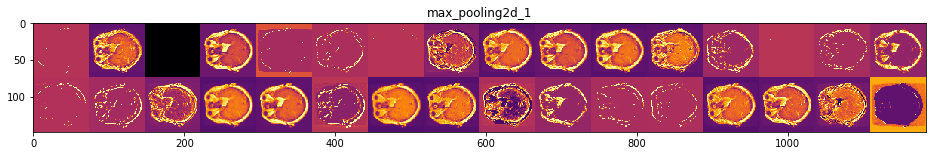

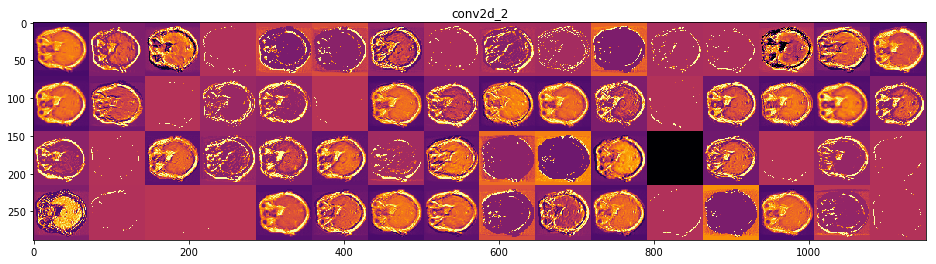

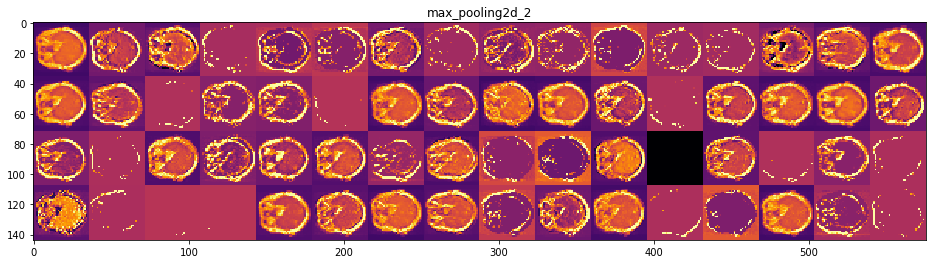

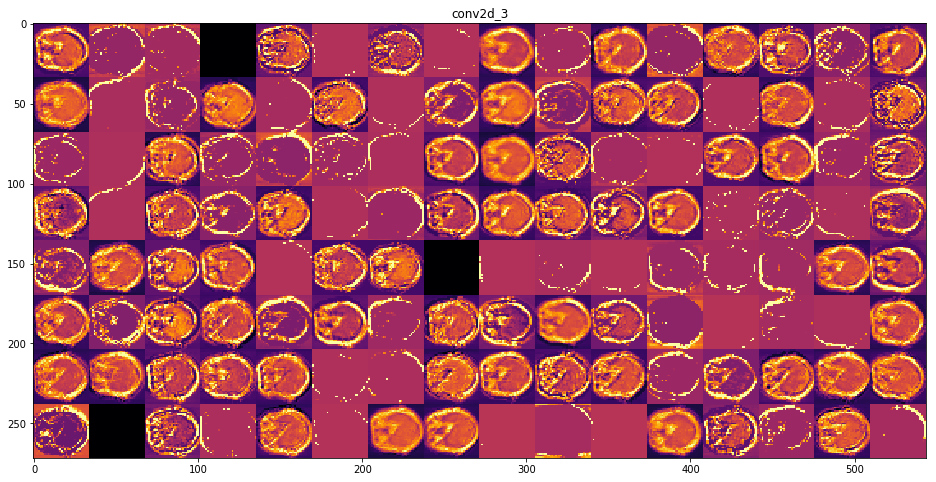

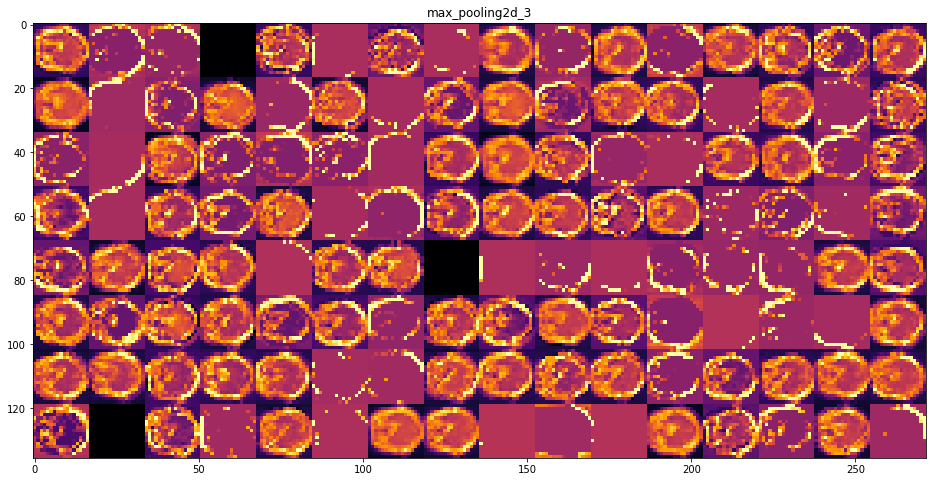

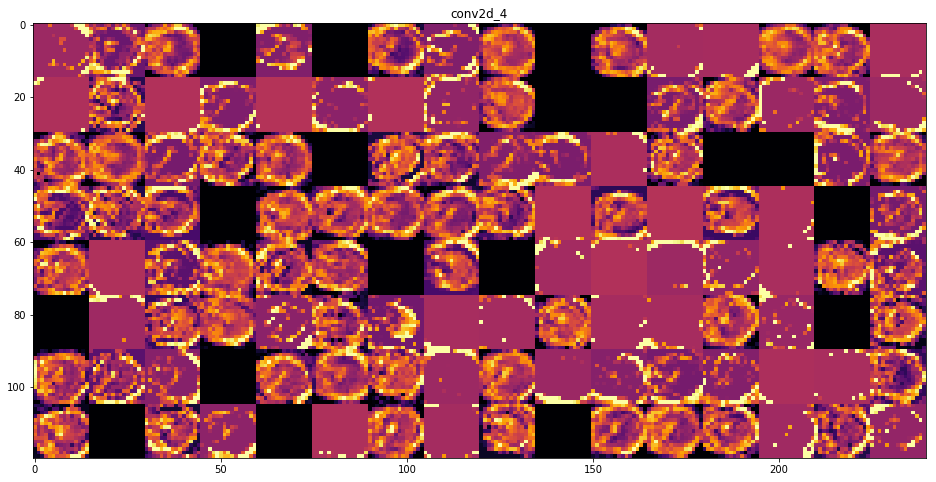

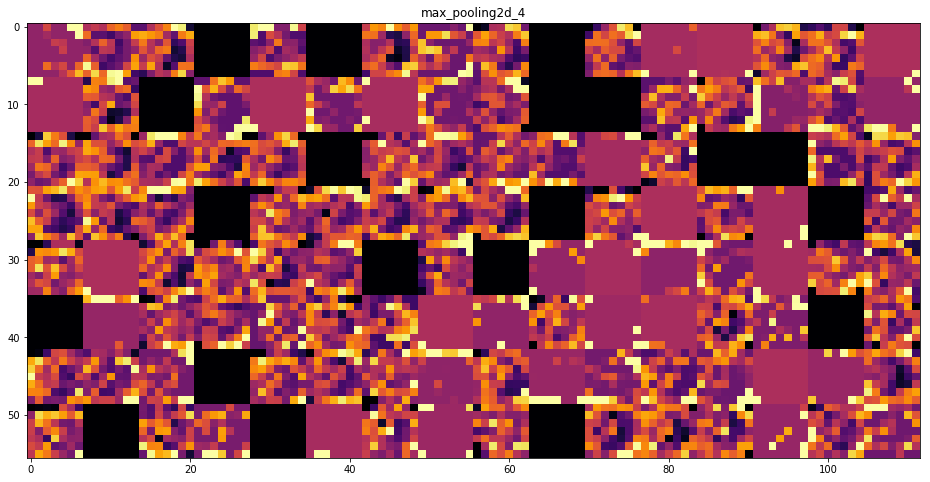

In [ ]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='inferno')

# Fit generator for the entire dataset with enhanced images

In [ ]:

filepath="Simplified_NOT_enhanced_Brain_Tumor_class"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
term=keras.callbacks.TerminateOnNaN()

callbacks_list = [checkpoint,term]


history2 = model2.fit_generator(train_generator1,
                              steps_per_epoch=20,
                              epochs=175,
                              validation_data=validation_generator1,
                              validation_steps=50,
                              callbacks=callbacks_list)

Epoch 1/175
20/20 [==============================] - 40s 2s/step - loss: 1.0689 - acc: 0.4469 - val_loss: 1.0337 - val_acc: 0.4612

Epoch 00001: val_acc improved from -inf to 0.46115, saving model to Simplified_NOT_enhanced_Brain_Tumor_class
Epoch 2/175
20/20 [==============================] - 37s 2s/step - loss: 1.0111 - acc: 0.4625 - val_loss: 0.9766 - val_acc: 0.4612

Epoch 00002: val_acc improved from 0.46115 to 0.46115, saving model to Simplified_NOT_enhanced_Brain_Tumor_class
Epoch 3/175
20/20 [==============================] - 37s 2s/step - loss: 0.9091 - acc: 0.5781 - val_loss: 0.8721 - val_acc: 0.6579

Epoch 00003: val_acc improved from 0.46115 to 0.65789, saving model to Simplified_NOT_enhanced_Brain_Tumor_class
Epoch 4/175
20/20 [==============================] - 36s 2s/step - loss: 0.8095 - acc: 0.6820 - val_loss: 0.7469 - val_acc: 0.6905

Epoch 00004: val_acc improved from 0.65789 to 0.69048, saving model to Simplified_NOT_enhanced_Brain_Tumor_class
Epoch 5/175
20/20 [====

20/20 [==============================] - 37s 2s/step - loss: 0.4256 - acc: 0.8391 - val_loss: 0.3744 - val_acc: 0.8546

Epoch 00040: val_acc did not improve from 0.85589
Epoch 41/175
20/20 [==============================] - 37s 2s/step - loss: 0.3985 - acc: 0.8469 - val_loss: 0.3868 - val_acc: 0.8183

Epoch 00041: val_acc did not improve from 0.85589
Epoch 42/175
20/20 [==============================] - 37s 2s/step - loss: 0.3730 - acc: 0.8531 - val_loss: 0.3744 - val_acc: 0.8647

Epoch 00042: val_acc improved from 0.85589 to 0.86466, saving model to Simplified_NOT_enhanced_Brain_Tumor_class
Epoch 43/175
20/20 [==============================] - 37s 2s/step - loss: 0.3919 - acc: 0.8451 - val_loss: 0.3730 - val_acc: 0.8321

Epoch 00043: val_acc did not improve from 0.86466
Epoch 44/175
20/20 [==============================] - 37s 2s/step - loss: 0.3375 - acc: 0.8687 - val_loss: 0.3587 - val_acc: 0.8634

Epoch 00044: val_acc did not improve from 0.86466
Epoch 45/175
20/20 [===============

20/20 [==============================] - 37s 2s/step - loss: 0.2593 - acc: 0.8895 - val_loss: 0.2869 - val_acc: 0.8860

Epoch 00082: val_acc did not improve from 0.88972
Epoch 83/175
20/20 [==============================] - 37s 2s/step - loss: 0.2615 - acc: 0.9000 - val_loss: 0.2820 - val_acc: 0.8897

Epoch 00083: val_acc did not improve from 0.88972
Epoch 84/175
20/20 [==============================] - 37s 2s/step - loss: 0.2768 - acc: 0.8828 - val_loss: 0.2889 - val_acc: 0.8922

Epoch 00084: val_acc improved from 0.88972 to 0.89223, saving model to Simplified_NOT_enhanced_Brain_Tumor_class
Epoch 85/175
20/20 [==============================] - 37s 2s/step - loss: 0.3230 - acc: 0.8797 - val_loss: 0.2920 - val_acc: 0.8860

Epoch 00085: val_acc did not improve from 0.89223
Epoch 86/175
20/20 [==============================] - 37s 2s/step - loss: 0.2946 - acc: 0.8859 - val_loss: 0.2968 - val_acc: 0.8822

Epoch 00086: val_acc did not improve from 0.89223
Epoch 87/175
20/20 [===============


Epoch 00123: val_acc did not improve from 0.90602
Epoch 124/175
20/20 [==============================] - 38s 2s/step - loss: 0.2220 - acc: 0.9234 - val_loss: 0.2489 - val_acc: 0.8910

Epoch 00124: val_acc did not improve from 0.90602
Epoch 125/175
20/20 [==============================] - 38s 2s/step - loss: 0.2003 - acc: 0.9408 - val_loss: 0.2310 - val_acc: 0.9048

Epoch 00125: val_acc did not improve from 0.90602
Epoch 126/175
20/20 [==============================] - 40s 2s/step - loss: 0.1984 - acc: 0.9156 - val_loss: 0.2541 - val_acc: 0.9060

Epoch 00126: val_acc improved from 0.90602 to 0.90602, saving model to Simplified_NOT_enhanced_Brain_Tumor_class
Epoch 127/175
20/20 [==============================] - 38s 2s/step - loss: 0.2240 - acc: 0.9156 - val_loss: 0.2348 - val_acc: 0.8947

Epoch 00127: val_acc did not improve from 0.90602
Epoch 128/175
20/20 [==============================] - 38s 2s/step - loss: 0.2065 - acc: 0.9224 - val_loss: 0.2329 - val_acc: 0.9098

Epoch 00128: val


Epoch 00166: val_acc did not improve from 0.92231
Epoch 167/175
20/20 [==============================] - 36s 2s/step - loss: 0.1600 - acc: 0.9380 - val_loss: 0.2333 - val_acc: 0.9160

Epoch 00167: val_acc did not improve from 0.92231
Epoch 168/175
20/20 [==============================] - 36s 2s/step - loss: 0.1386 - acc: 0.9469 - val_loss: 0.2113 - val_acc: 0.9211

Epoch 00168: val_acc did not improve from 0.92231
Epoch 169/175
20/20 [==============================] - 36s 2s/step - loss: 0.1524 - acc: 0.9391 - val_loss: 0.2010 - val_acc: 0.9160

Epoch 00169: val_acc did not improve from 0.92231
Epoch 170/175
20/20 [==============================] - 37s 2s/step - loss: 0.1359 - acc: 0.9516 - val_loss: 0.1988 - val_acc: 0.9198

Epoch 00170: val_acc did not improve from 0.92231
Epoch 171/175
20/20 [==============================] - 36s 2s/step - loss: 0.1232 - acc: 0.9575 - val_loss: 0.1996 - val_acc: 0.9185

Epoch 00171: val_acc did not improve from 0.92231
Epoch 172/175
20/20 [========

### Plotting train and validation loss and accuracy

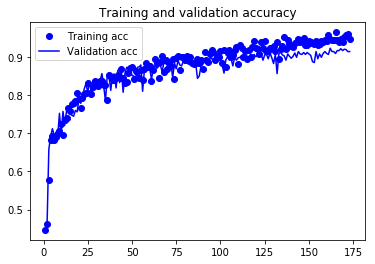

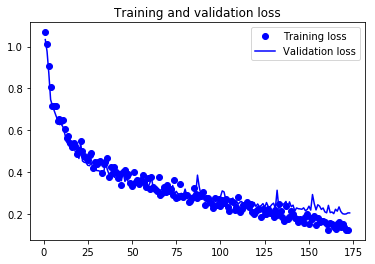

In [ ]:

acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Training on a VGG16 convolution base with enhanced tumor

The image size was resized and reduced to 150 x 150 by the image data generator where batches of 32 images were used as an input for the VGG16 convolution base. The convolution base ejected the Max pooling output of 4x4x512 which was flattened to 1x1x8192. A fully connected layer with ReLU activation of 256 output dimension was then added for a smooth reduction. Furthermore, this was supplemented with the final output layer of 3 classifying nodes with sigmoid activation. 

In [ ]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
include_top=False,
input_shape=(150, 150, 3))

In [ ]:
model3 = models.Sequential()
model3.add(conv_base)
model3.add(layers.Flatten())
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dense(3, activation='sigmoid'))
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 771       
Total params: 16,812,867
Trainable params: 16,812,867
Non-trainable params: 0
_________________________________________________________________


### Freezing vgg16 convolutional base to reduce the number of trainable parameters

In [ ]:
conv_base.trainable = False
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 771       
Total params: 16,812,867
Trainable params: 2,098,179
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model3.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc'])

In [ ]:
 
filepath="VGG16_enhanced_Brain_Tumor_class.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
term=keras.callbacks.TerminateOnNaN()

callbacks_list = [checkpoint,term]


history3 = model3.fit_generator(train_generator,
                              steps_per_epoch=20,
                              epochs=75,
                              validation_data=validation_generator,
                              validation_steps=50,
                              callbacks=callbacks_list)

Epoch 1/75
20/20 [==============================] - 283s 14s/step - loss: 0.8667 - acc: 0.5734 - val_loss: 0.6003 - val_acc: 0.7325

Epoch 00001: val_acc improved from -inf to 0.73246, saving model to VGG16_enhanced_Brain_Tumor_class.hdf5
Epoch 2/75
20/20 [==============================] - 280s 14s/step - loss: 0.5525 - acc: 0.7725 - val_loss: 0.4640 - val_acc: 0.8377

Epoch 00002: val_acc improved from 0.73246 to 0.83772, saving model to VGG16_enhanced_Brain_Tumor_class.hdf5
Epoch 3/75
20/20 [==============================] - 281s 14s/step - loss: 0.4188 - acc: 0.8344 - val_loss: 0.3959 - val_acc: 0.8421

Epoch 00003: val_acc improved from 0.83772 to 0.84211, saving model to VGG16_enhanced_Brain_Tumor_class.hdf5
Epoch 4/75
20/20 [==============================] - 279s 14s/step - loss: 0.3824 - acc: 0.8547 - val_loss: 0.3893 - val_acc: 0.8477

Epoch 00004: val_acc improved from 0.84211 to 0.84774, saving model to VGG16_enhanced_Brain_Tumor_class.hdf5
Epoch 5/75
20/20 [=================


Epoch 00039: val_acc improved from 0.93358 to 0.93546, saving model to VGG16_enhanced_Brain_Tumor_class.hdf5
Epoch 40/75
20/20 [==============================] - 278s 14s/step - loss: 0.0882 - acc: 0.9781 - val_loss: 0.1741 - val_acc: 0.9273

Epoch 00040: val_acc did not improve from 0.93546
Epoch 41/75
20/20 [==============================] - 277s 14s/step - loss: 0.0866 - acc: 0.9828 - val_loss: 0.1862 - val_acc: 0.9198

Epoch 00041: val_acc did not improve from 0.93546
Epoch 42/75
20/20 [==============================] - 280s 14s/step - loss: 0.0754 - acc: 0.9891 - val_loss: 0.1487 - val_acc: 0.9380

Epoch 00042: val_acc improved from 0.93546 to 0.93797, saving model to VGG16_enhanced_Brain_Tumor_class.hdf5
Epoch 43/75
20/20 [==============================] - 278s 14s/step - loss: 0.0744 - acc: 0.9891 - val_loss: 0.1683 - val_acc: 0.9242

Epoch 00043: val_acc did not improve from 0.93797
Epoch 44/75
20/20 [==============================] - 277s 14s/step - loss: 0.0830 - acc: 0.9828

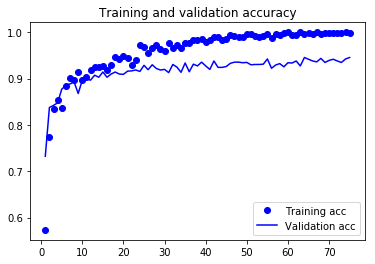

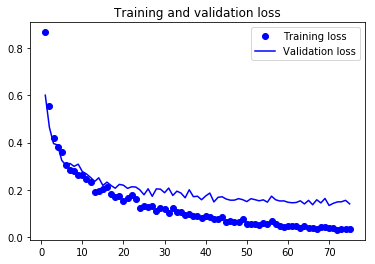

In [ ]:
acc = history3.history['acc']
val_acc = history3.history['val_acc']
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# VGG16 convolution base for un-enhanced images

In [ ]:
conv_base2 = VGG16(weights='imagenet',
include_top=False,
input_shape=(150, 150, 3))

In [ ]:
model4 = models.Sequential()
model4.add(conv_base2)
model4.add(layers.Flatten())
model4.add(layers.Dense(256, activation='relu'))
model4.add(layers.Dense(3, activation='sigmoid'))
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 771       
Total params: 16,812,867
Trainable params: 16,812,867
Non-trainable params: 0
_________________________________________________________________


### Freezing vgg16 convolutional base to reduce the number of trainable parameters

In [ ]:
#Freezing model
conv_base2.trainable = False
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 771       
Total params: 16,812,867
Trainable params: 2,098,179
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model4.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc'])

In [ ]:

filepath="VGG16_NOT_enhanced_Brain_Tumor_class.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
term=keras.callbacks.TerminateOnNaN()

callbacks_list = [checkpoint,term]


history4 = model4.fit_generator(train_generator1,
                              steps_per_epoch=20,
                              epochs=75,
                              validation_data=validation_generator1,
                              validation_steps=50,
                              callbacks=callbacks_list)

Epoch 1/75
20/20 [==============================] - 281s 14s/step - loss: 0.8336 - acc: 0.6177 - val_loss: 0.5879 - val_acc: 0.7356

Epoch 00001: val_acc improved from -inf to 0.73559, saving model to VGG16_NOT_enhanced_Brain_Tumor_class.hdf5
Epoch 2/75
20/20 [==============================] - 278s 14s/step - loss: 0.5483 - acc: 0.7781 - val_loss: 0.4815 - val_acc: 0.7914

Epoch 00002: val_acc improved from 0.73559 to 0.79135, saving model to VGG16_NOT_enhanced_Brain_Tumor_class.hdf5
Epoch 3/75
20/20 [==============================] - 277s 14s/step - loss: 0.4875 - acc: 0.7734 - val_loss: 0.4320 - val_acc: 0.8195

Epoch 00003: val_acc improved from 0.79135 to 0.81955, saving model to VGG16_NOT_enhanced_Brain_Tumor_class.hdf5
Epoch 4/75
20/20 [==============================] - 278s 14s/step - loss: 0.3980 - acc: 0.8328 - val_loss: 0.4006 - val_acc: 0.8440

Epoch 00004: val_acc improved from 0.81955 to 0.84398, saving model to VGG16_NOT_enhanced_Brain_Tumor_class.hdf5
Epoch 5/75
20/20 [=

In [ ]:

acc = history4.history['acc']
val_acc = history4.history['val_acc']
loss = history4.history['loss']
val_loss = history4.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

##### Testing classification by Simplified model trained on enhanced images

In [28]:
TumorClass('C:\\Anaconda3\\3246\\Project1\\Simplified_enhanced_Brain_Tumor_class.hdf5','C:\\Anaconda3\\3246\\Project1\\test1\\m\\291.mat.png')

meningioma


##### Testing classification by Simplified model trained on NOT-enhanced images

In [29]:
TumorClass('C:\\Anaconda3\\3246\\Project1\\Simplified_NOT_enhanced_Brain_Tumor_class.hdf5','C:\\Anaconda3\\3246\\Project1\\test1\\p\\1079.mat.png')

pituitary tumor


##### Testing classification by VGG-16 convolution base model trained on enhanced images

In [30]:
TumorClass('C:\\Anaconda3\\3246\\Project1\\VGG16_enhanced_Brain_Tumor_class.hdf5','C:\\Anaconda3\\3246\\Project1\\test1\\p\\1079.mat.png')

C:\Anaconda3\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


pituitary tumor


##### Testing classification by VGG-16 convolution base model trained on NOT-enhanced images

In [32]:
TumorClass('C:\\Anaconda3\\3246\\Project1\\VGG16_NOT_enhanced_Brain_Tumor_class.hdf5','C:\\Anaconda3\\3246\\Project1\\test\\g\\829.mat.png')

C:\Anaconda3\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


glioma


# Analyzing the results of accuracy and losses plots

###### As seen above, both plots are very close to each other when it comes to accuracy and training and validation losses. The key difference to note however the learning rate, time, number of epochs it took to get the desired result. The simplified model achieved its highest validation accuracy of 92% with about 160 epochs where its learning rate was 0.25e-4 whereas VGG16-conv-base model reached a 94% validation accuracy with around 60 epochs at 1e-4 learning rate. The VGG based model however took 7-8 times more time per epoch for it to be trained. The simplified network could be trained for a longer period of times but would simply stop improving and eventually would encounter a Nan loss which would diverge the model and give bad results. To fix, the given issues, a callback for training termination when Nan loss was added to the model. This in conjunction with the callback to save models whenever lowest validation loss is achieved provided with the best possible tuning of the simplified model.

###### Both models were also trained to be used with un-enhanced versions of the same image dataset and split. Despite no enhancement, the results were found to be very competitive with only 2-3% difference in the validation accuracy that was achieved. 

###### Both models trained with unenhanced images peaked at around 89-91% validation accuracy. Both had previously mentioned learning rates (0.25e-4 for simplified and 1e-4 for VGG16 conv base), similar number of epochs and the same steps per epoch. The 2-3% difference in validation accuracy is only due the difficulty of detecting tumors and classifying them without any contrast/brightness enhancement of the tumor region.




# Conclusions

####  Both the simplified and VGG-16 convolution-base model have very high validation accuracy rates (89-95%) in predicting the tumor type of the patient. CNN’s can be effectively used as recommendation tools to radiologists that can enhance tumor regions in fMRI images. The function “TumorClass” can utilize any of 4 models used and make a prediction about the tumor type. CNN based models like the ones created in project beat a lot of the previous machine learning models used to classify only with 85% accuracy. Previous processes include having a tumor based region of interest and various forms of texture analysis performed on high definition image datasets to produce a prediction. CNN like discussed in this report can even train and predict with fMRI scans without highlighting the tumor regions. CNN’s have the potential to save lives by helping with diagnosis and classification of brain tumor types amongst ailing patients. The Brain tumor diagnosis and treatment after its classification by a medical health professional is a very time sensitive process and the simplified model can be of great value to medical-health professionals in being able to broadly classify the tumor to speed up treatment.